In [1]:
from evaluation_utils import read_global_results, get_best_configuration_per_model
from constants import MODE_1_PROCESSED_DIR, TEST_METRIC, ENCODERS, ENCODER_COLORS, \
                    TRAINING_SCHEMES, TRAINING_SCHEME_COLORS, SSL_MODELS, BASELINES, FONT, SINGLE_ENCODER_MODELS
import pandas as pd
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from collections import defaultdict
import itertools
from matplotlib.ticker import MultipleLocator

In [2]:
# Read Mode 1 data (raw)
df = read_global_results(MODE_1_PROCESSED_DIR)

1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
8.ndjson
9.ndjson
10.ndjson
11.ndjson
concatenating


In [3]:
best_configurations_all = get_best_configuration_per_model(df, TEST_METRIC, n_best=0)

Sampled param counts for PF:
--------------
hidden channels-GCN:
16: 2592
8: 2592
--------------
hidden channels-GAT:
16: 7776
8: 7776
--------------
hidden channels-GIN:
16: 2592
8: 2592
--------------

num layers-GCN:
1: 2592
2: 2592
--------------
num layers-GAT:
1: 7776
2: 7776
--------------
num layers-GIN:
1: 2592
2: 2592
--------------

dropout-GCN:
0.3: 1296
0.0: 1296
0.8: 1296
0.5: 1296
--------------
dropout-GAT:
0.3: 3888
0.0: 3888
0.8: 3888
0.5: 3888
--------------
dropout-GIN:
0.3: 1296
0.0: 1296
0.8: 1296
0.5: 1296
--------------

downstream lr-GCN:
0.3: 1728
0.003: 1728
0.01: 1728
--------------
downstream lr-GAT:
0.3: 5184
0.003: 5184
0.01: 5184
--------------
downstream lr-GIN:
0.3: 1728
0.003: 1728
0.01: 1728
--------------

pretext epochs-GCN:
50: 2592
100: 2592
--------------
pretext epochs-GAT:
50: 7776
100: 7776
--------------
pretext epochs-GIN:
50: 2592
100: 2592
--------------

pretext lr-GCN:
0.0001: 1728
0.01: 1728
0.001: 1728
--------------
pretext lr-GAT:
0

/tmp/ipykernel_8523/687910639.py:144: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


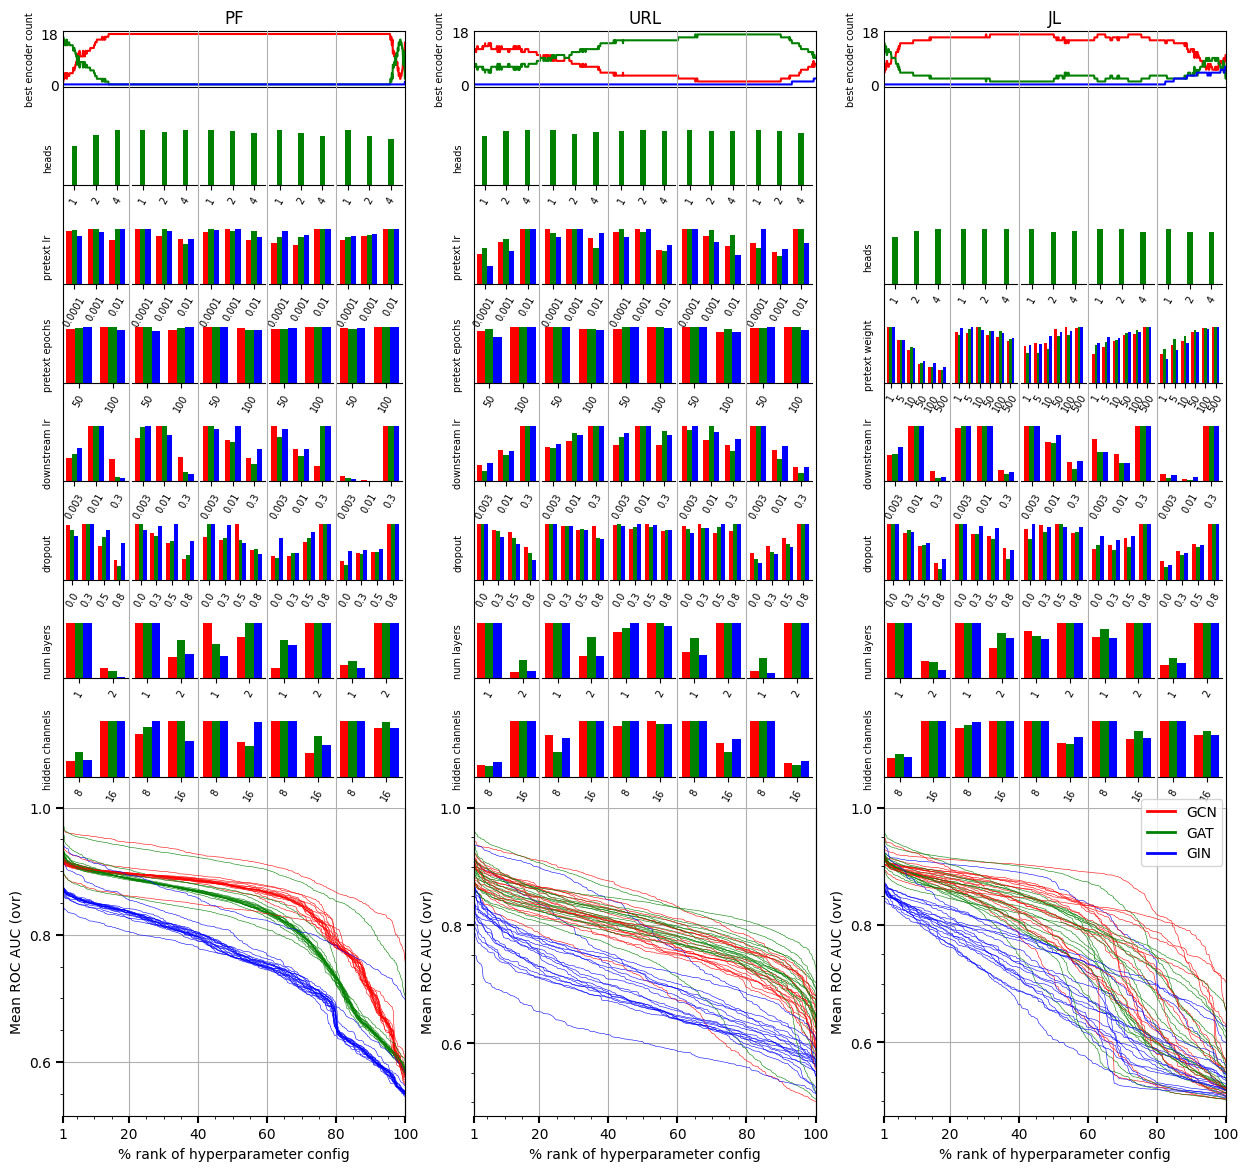

In [9]:
# Plotting rank of configurations for training_scheme, encoder
plt.rcParams["font.family"] = FONT
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for axi, (ts, ax) in enumerate(zip(TRAINING_SCHEMES, axs)):
    best_encoders_y = {}                        
    best_encoders_x = np.linspace(0,100, 1000)
    param_groups = {0: defaultdict(lambda : defaultdict(lambda: defaultdict(int))), # group/encoder/param/value/count
                    20: defaultdict(lambda : defaultdict(lambda: defaultdict(int))),
                    40: defaultdict(lambda : defaultdict(lambda: defaultdict(int))),
                    60: defaultdict(lambda : defaultdict(lambda: defaultdict(int))),
                    80: defaultdict(lambda : defaultdict(lambda: defaultdict(int)))}
    unique_param_values = defaultdict(set)
    for encoder in ENCODERS:
        best_encoders_y[encoder] = [0] * 1000
    for ssl_model in SSL_MODELS:
        encoder_perf = {}
        for encoder in ENCODERS:
            model = f'{encoder}_{ssl_model}_{ts}'
            if ssl_model in SINGLE_ENCODER_MODELS:
                continue
            if model in best_configurations_all.keys():
                configurations = best_configurations_all[model]
                metric = configurations[f'{model}_{TEST_METRIC}']
                percent_rank = np.arange(0, metric.shape[0]) / metric.shape[0] * 100
                encoder_perf[encoder] = percent_rank, metric
                encoder = [encoder for encoder in ENCODERS if encoder in model][0]
                ax.plot(percent_rank+1, metric, color=ENCODER_COLORS[encoder], label=encoder, linewidth=0.4)
                configurations['rank'] = percent_rank
                # Figuring out data for distributions
                for index, row in configurations.iterrows():
                    rank = row['rank']
                    for c in configurations.columns:
                        param = c.removeprefix(f'{model}_')
                        param = param.removeprefix('train_')
                        param = param.removeprefix('encoder_')
                        param = param.replace('_', " ")
                        if param in ['hidden channels', 'num layers', 'dropout', 'downstream lr', 'pretext epochs', 'pretext lr', 'pretext weight', 'heads']:
                            if rank < 20: group = 0
                            elif rank < 40: group = 20
                            elif rank < 60: group = 40
                            elif rank < 80: group = 60
                            else          : group = 80
                            param_value = row[c]
                            if param in ['hidden channels', 'num layers', 'pretext epochs', 'pretext weight', 'heads']:
                                param_value = int(param_value)
                            param_groups[group][encoder][param][param_value] += 1
                            unique_param_values[param].add(param_value)
        # Figuring out data for top plot
        if len(encoder_perf) == len(ENCODERS):
            for idx, x in enumerate(best_encoders_x):
                gcn_perf = encoder_perf["GCN"][1][np.argmin(np.abs(x - encoder_perf["GCN"][0]))]
                gat_perf = encoder_perf["GAT"][1][np.argmin(np.abs(x - encoder_perf["GAT"][0]))]
                gin_perf = encoder_perf["GIN"][1][np.argmin(np.abs(x - encoder_perf["GIN"][0]))]
                if gcn_perf > gat_perf and gcn_perf > gin_perf:
                    best_encoders_y["GCN"][idx] += 1
                elif gat_perf > gcn_perf and gat_perf > gin_perf:
                    best_encoders_y["GAT"][idx] += 1
                elif gin_perf > gcn_perf and gin_perf > gat_perf:
                    best_encoders_y["GIN"][idx] += 1

    # Main plot (bottom)
    ax.title.set_text(ts)
    ax.set_xlabel("% rank of hyperparameter config")
    ax.set_ylabel("Mean ROC AUC (ovr)")
    ax.set_xticks([1, 20, 40, 60, 80, 100])
    ax.set_yticks([0.6, 0.8, 1.0])
    ax.set_xlim(1, 100)
    ax.grid()
    for line in ax.get_xgridlines():
        line.set_zorder(100)
        line.set_clip_on(False)
        line.set_clip_path(None)
        line.set_ydata([0, 3.52])
    for line in [ax.get_xgridlines()[0], ax.get_xgridlines()[-1]]:
        line.set_color("black")
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.tick_params(axis='y', direction='out', length=5, width=1.5)
    ax.tick_params(axis='x', direction='out', length=5, width=1.5)
    [ax.spines[spine].set_visible(False) for spine in ['top']]

    # Middle distribution plots
    params = param_groups[0]["GAT"].keys()
    for i, group in enumerate(param_groups.keys()):
        for j, param in enumerate(params):
            unique_values = sorted(unique_param_values[param])
            ax2 = ax.inset_axes((0 + 0.2*i, 1.1 + 0.32*j, 0.19, 0.18))
            ax2.set_ylim(0, 1)
            [ax2.spines[spine].set_visible(False) for spine in ['top', 'right', 'left']]
            width = 0.25
            x_GCN = list(range(len(unique_values)))
            x_GAT = [x + width for x in x_GCN]
            x_GIN = [x + 2*width for x in x_GCN]
            max_GCN = max([1] + [param_groups[group]["GCN"][param][value] for value in unique_values])
            max_GAT = max([1] + [param_groups[group]["GAT"][param][value] for value in unique_values])
            max_GIN = max([1] + [param_groups[group]["GIN"][param][value] for value in unique_values])
            ax2.bar(x_GCN, [param_groups[group]["GCN"][param][value]/max_GCN for value in unique_values], width=width, color=ENCODER_COLORS["GCN"])
            ax2.bar(x_GAT, [param_groups[group]["GAT"][param][value]/max_GAT for value in unique_values], width=width, color=ENCODER_COLORS["GAT"])
            ax2.bar(x_GIN, [param_groups[group]["GIN"][param][value]/max_GIN for value in unique_values], width=width, color=ENCODER_COLORS["GIN"])
            ax2.set_xticks(x_GAT, unique_values, rotation=60, fontsize=7)
            ax2.set_yticks([])
            ax2.set_zorder(1)
            if i == 0:
                ax2.set_ylabel(param, fontsize=7)


    # Top plot
    ax2 = ax.inset_axes((0, 1.1 + 0.32*7, 1, 0.18))
    ax2.plot(best_encoders_x, best_encoders_y["GCN"], color=ENCODER_COLORS["GCN"], label=encoder)
    ax2.plot(best_encoders_x, best_encoders_y["GAT"], color=ENCODER_COLORS["GAT"], label=encoder)
    ax2.plot(best_encoders_x, best_encoders_y["GIN"], color=ENCODER_COLORS["GIN"], label=encoder)
    [ax2.spines[spine].set_visible(False) for spine in ["left", 'right']]
    ax2.set_xticks([])
    ax2.set_yticks([0, best_encoders_y["GCN"][0] + best_encoders_y["GAT"][0] + best_encoders_y["GIN"][0]])
    ax2.tick_params(axis='y', direction='in', length=0, width=0)
    ax2.set_zorder(1)
    ax2.set_xlim(1, 100)
    ax2.set_ylabel("best encoder count", fontsize=7)

# Final plotting details 
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
leg = plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.01, 1.05))
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)
#plt.suptitle("Encoder performance dropoff of hyperparameter configurations for each training scheme")
plt.tight_layout()

In [12]:
import  matplotlib.font_manager
flist = matplotlib.font_manager.get_fontconfig_fonts()
names = [matplotlib.font_manager.FontProperties(fname=fname).get_name() for fname in flist]
print(names)

['URW Bookman', 'Nimbus Sans', 'Nimbus Mono PS', 'Liberation Mono', 'Nimbus Sans Narrow', 'Nimbus Sans', 'DejaVu Sans', 'P052', 'Liberation Mono', 'Nimbus Sans', 'Nimbus Roman', 'DejaVu Sans', 'Liberation Mono', 'P052', 'C059', 'Nimbus Sans Narrow', 'Nimbus Roman', 'URW Bookman', 'Nimbus Roman', 'Nimbus Roman', 'DejaVu Sans', 'Nimbus Mono PS', 'D050000L', 'Nimbus Sans Narrow', 'P052', 'DejaVu Sans', 'DejaVu Sans', 'C059', 'DejaVu Sans', 'DejaVu Sans', 'URW Gothic', 'URW Bookman', 'URW Gothic', 'DejaVu Sans Mono', 'URW Gothic', 'C059', 'Nimbus Mono PS', 'C059', 'Nimbus Sans', 'DejaVu Sans', 'Nimbus Mono PS', 'URW Gothic', 'DejaVu Sans', 'DejaVu Sans Mono', 'Nimbus Sans Narrow', 'URW Bookman', 'DejaVu Sans Mono', 'Z003', 'DejaVu Sans Mono', 'P052', 'Liberation Mono']


/tmp/ipykernel_19381/442772557.py:2: MatplotlibDeprecationWarning: The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.
  flist = matplotlib.font_manager.get_fontconfig_fonts()


In [66]:
best_configurations_all["GAT_AttributeMask_JL"]

,GAT_AttributeMask_JL_encoder_in_channels,GAT_AttributeMask_JL_encoder_hidden_channels,GAT_AttributeMask_JL_encoder_num_layers,GAT_AttributeMask_JL_encoder_dropout,GAT_AttributeMask_JL_train_downstream_lr,GAT_AttributeMask_JL_train_downstream_epochs,GAT_AttributeMask_JL_train_patience,GAT_AttributeMask_JL_train_pretext_weight,GAT_AttributeMask_JL_encoder_heads,GAT_AttributeMask_JL_test_rocauc_ovr,rank
0,16,16,1,0.3,0.010,250,100,5,1,0.923743,0.000000
1,16,16,1,0.3,0.010,250,100,5,4,0.923698,0.347222
2,16,8,1,0.3,0.010,250,100,5,4,0.921264,0.694444
3,16,16,1,0.3,0.010,250,100,5,2,0.919381,1.041667
4,16,8,1,0.3,0.010,250,100,50,2,0.917692,1.388889
...,...,...,...,...,...,...,...,...,...,...,...
283,16,8,1,0.0,0.010,250,100,500,4,0.865564,98.263889
284,16,16,2,0.0,0.003,250,100,500,2,0.865550,98.611111
285,16,16,1,0.0,0.003,250,100,500,1,0.865265,98.958333
286,16,8,1,0.8,0.010,250,100,5,2,0.865132,99.305556


In [63]:
for ts in ["JL"]:
    for ssl_model in SSL_MODELS:
        for encoder in ENCODERS:
            model = f"{encoder}_{ssl_model}_{ts}"
            print(f'{model}: {len(best_configurations_all[model])}')

GCN_AttributeMask_JL: 288
GAT_AttributeMask_JL: 288
GIN_AttributeMask_JL: 288
GCN_CorruptedEmbeddingsReconstruction_JL: 288
GAT_CorruptedEmbeddingsReconstruction_JL: 288
GIN_CorruptedEmbeddingsReconstruction_JL: 288
GCN_CorruptedFeaturesReconstruction_JL: 288
GAT_CorruptedFeaturesReconstruction_JL: 288
GIN_CorruptedFeaturesReconstruction_JL: 288
GCN_EdgeMask_JL: 288
GAT_EdgeMask_JL: 288
GIN_EdgeMask_JL: 288
GCN_GAE_JL: 288
GAT_GAE_JL: 288
GIN_GAE_JL: 288
GCN_NodeClusteringWithAlignment_JL: 288
GAT_NodeClusteringWithAlignment_JL: 288
GIN_NodeClusteringWithAlignment_JL: 288
GCN_S2GRL_JL: 288
GAT_S2GRL_JL: 288
GIN_S2GRL_JL: 288
GCN_PairwiseAttrSim_JL: 288
GAT_PairwiseAttrSim_JL: 288
GIN_PairwiseAttrSim_JL: 288
GCN_GraphPartitioning_JL: 288
GAT_GraphPartitioning_JL: 288
GIN_GraphPartitioning_JL: 288
GCN_BGRL_JL: 288
GAT_BGRL_JL: 288
GIN_BGRL_JL: 288
GCN_GBT_JL: 288
GAT_GBT_JL: 288
GIN_GBT_JL: 288
GCN_GCA_JL: 288
GAT_GCA_JL: 288
GIN_GCA_JL: 288
GCN_SelfGNNPPR_JL: 288


KeyError: 'GAT_SelfGNNPPR_JL'

In [69]:
test = get_best_configuration_per_model(df, TEST_METRIC, n_best=0)

In [68]:
test["GAT_AttributeMask_JL"]

,GAT_AttributeMask_JL_encoder_in_channels,GAT_AttributeMask_JL_encoder_hidden_channels,GAT_AttributeMask_JL_encoder_num_layers,GAT_AttributeMask_JL_encoder_dropout,GAT_AttributeMask_JL_train_downstream_lr,GAT_AttributeMask_JL_train_downstream_epochs,GAT_AttributeMask_JL_train_patience,GAT_AttributeMask_JL_train_pretext_weight,GAT_AttributeMask_JL_encoder_heads,GAT_AttributeMask_JL_test_rocauc_ovr
0,16,16,1,0.3,0.010,250,100,5,1,0.923743
1,16,16,1,0.3,0.010,250,100,5,4,0.923698
2,16,8,1,0.3,0.010,250,100,5,4,0.921264
3,16,16,1,0.3,0.010,250,100,5,2,0.919381
4,16,8,1,0.3,0.010,250,100,50,2,0.917692
...,...,...,...,...,...,...,...,...,...,...
283,16,8,1,0.0,0.010,250,100,500,4,0.865564
284,16,16,2,0.0,0.003,250,100,500,2,0.865550
285,16,16,1,0.0,0.003,250,100,500,1,0.865265
286,16,8,1,0.8,0.010,250,100,5,2,0.865132
